# Classes 4 - Data classes round 2

In [1]:
# Import statements
import pandas as pd
import os
import datetime as dt
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoLocator
import itertools
from itertools import product
import numpy as np
import csv
import operator

# Directories for reading and writing data
thedir = os.getcwd()
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
extdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/external'))
figdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))

# load data (reference data set of lcd and aws stations from 2018)
data_test = pd.read_csv(F'{extdir}/ref_2018.csv')
data_ = data_test[['Date_time_CET','BOLL_LCD_TEMP',
       'BOLL_AWS_TEMP', 'BOLL_PRECIP', 'BOLL_RADIATION_GLOBAL',
       'BOLL_WIND_SPEED_mean', 'ZOLL_STEVENSON_LCD_TEMP', 'ZOLL_2m_LCD_TEMP',
       'ZOLL_3m_LCD_TEMP', 'ZOLL_AWS_TEMP', 'ZOLL_RADIATION_GLOBAL',
       'ZOLL_SUNSHINE', 'ZOLL_PRECIP', 'ZOLL_WIND_SPEED_MEAN', 'AFU_LCD_TEMP',
       'AFU_AWS_TEMP', 'AFU_WIND_SPEED_MEAN', 'AFU_RADIATION_GLOBAL']]
data_.set_index('Date_time_CET',inplace=True)

In [2]:
# define class (update value func isn't necessary...)

class Thing:
    def __init__(self, value, index, header):
        self.name = header
        self.time = dt.datetime.strptime(index,'%d.%m.%Y %H:%M')
        self.value = value
        self.station = header[:3].lower()
        if 'LCD' in header:
            self.stype = 'lcd'
        else:
            self.stype = 'aws'
        if 'TEMP' in header:
            self.qty = 'temp'
        elif 'SUN':
            self.qty = 'sun'
        elif 'RADI':
            self.qty = 'rad'
        elif 'WIND':
            self.qty = 'wind'
        elif 'PREC':
            self.qty = 'prec'
    
    def get_period(self, strfkey):
        return dt.datetime.strftime(self.time,strfkey)
    
    def update_value(self,value):
        self.value = value

## Dictionary
Following code defines the variables stored with each data point (except for the values and the time samps!)

In [3]:
names = ['BOLL_LCD_TEMP','BOLL_AWS_TEMP', 'BOLL_PRECIP', 'BOLL_RADIATION_GLOBAL','BOLL_WIND_SPEED_mean', 'ZOLL_STEVENSON_LCD_TEMP',
         'ZOLL_2m_LCD_TEMP','ZOLL_3m_LCD_TEMP', 'ZOLL_AWS_TEMP', 'ZOLL_RADIATION_GLOBAL','ZOLL_SUNSHINE', 'ZOLL_PRECIP', 'ZOLL_WIND_SPEED_MEAN',
         'AFU_LCD_TEMP', 'AFU_AWS_TEMP', 'AFU_WIND_SPEED_MEAN', 'AFU_RADIATION_GLOBAL']
period_keys = {'hour':'%H','month':'%m','year':'%Y','day':'%j'}
qty = ['temp','wind','rad','sun','prec']
station = ['bol','zol','afu']
key = period_keys['day']

## Create list of objects

In [4]:
cols = data_.columns
mylist = []
for index,rows in data_.iterrows():
        mylist.append([Thing(data_.at[index,index_c],index,index_c) for index_c in cols])
ad = [x for y in mylist for x in y]
ad = sorted(ad, key=operator.attrgetter('time'))
times = list(set([x.time for x in ad]))
times = sorted(times)

## Fix incorrect data 
Bad data is keyed as -9999, following code replaces the bad valeus with the mean from the previous and next hour (excluding any potential bad values that also occur in that hour).

In [5]:
wrong = [x for x in ad if x.value < -50]
for i in wrong:
    lower = [x.value for x in ad if (x.name == i.name) & (i.time - timedelta(hours=1) < x.time < i.time) & (x.value > -50)]
    higher = [x.value for x in ad if (x.name == i.name) & (i.time < x.time < i.time + timedelta(hours=1)) & (x.value > -50)]
    new_val = (sum(lower) + sum(higher))/(len(lower) + len(higher))
    i.update_value(new_val)

In [6]:
a = [x.value for x in ad if x.name == 'BOLL_AWS_TEMP']
a[17000]

16.1

In [7]:
df = pd.DataFrame(a)

# AWS - LCD differences
Gets difference and cum difference for each data instance

In [8]:
# get values from Thing class (Sensor reading)
aws = [x.value for x in ad if x.name == 'BOLL_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'BOLL_LCD_TEMP']
# subtract aws - lcd for readings
diff = [x - y for x, y in zip(aws, lcd)]
# turn into pd dataframe, turn time pd dataframe
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
# use cumsum function to create a new cumsum df
cumsum = df.cumsum()
# concat dfs together
bvals = pd.concat([cumsum,diff,md],axis = 1)
# reindex columns and rows
bvals.columns = ['Boll_sum','Boll_diff','time']
bvals.set_index('time',inplace=True,drop=True)

## same as above for each lcd-aws sensor pair. Should be turned into a loop but I got stuck making it...

aws = [x.value for x in ad if x.name == 'AFU_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'AFU_LCD_TEMP']
diff = [x - y for x, y in zip(aws, lcd)]
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
cumsum = df.cumsum()
avals = pd.concat([cumsum,diff,md],axis = 1)
avals.columns = ['afu_sum','afu_diff','time']
avals.set_index('time',inplace=True,drop=True)

aws = [x.value for x in ad if x.name == 'ZOLL_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'ZOLL_STEVENSON_LCD_TEMP']
diff = [x - y for x, y in zip(aws, lcd)]
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
cumsum = df.cumsum()
zvals = pd.concat([cumsum,diff,md],axis = 1)
zvals.columns = ['zoll_sum_s','zoll_diff_s','time']
zvals.set_index('time',inplace=True,drop=True)

aws = [x.value for x in ad if x.name == 'ZOLL_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'ZOLL_2m_LCD_TEMP']
diff = [x - y for x, y in zip(aws, lcd)]
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
cumsum = df.cumsum()
zvals2 = pd.concat([cumsum,diff,md],axis = 1)
zvals2.columns = ['zoll_sum_2','zoll_diff_2','time']
zvals2.set_index('time',inplace=True,drop=True)

aws = [x.value for x in ad if x.name == 'ZOLL_AWS_TEMP']
lcd = [x.value for x in ad if x.name == 'ZOLL_3m_LCD_TEMP']
diff = [x - y for x, y in zip(aws, lcd)]
diff = pd.DataFrame(diff)
md = pd.DataFrame(times)
cumsum = df.cumsum()
zvals3 = pd.concat([cumsum,diff,md],axis = 1)
zvals3.columns = ['zoll_sum_3m','zoll_diff_3m','time']
zvals3.set_index('time',inplace=True,drop=True)

# concat the df from each sensor into 1
cumsums = [zvals3,zvals2,zvals,bvals,avals]
df = pd.concat(cumsums,axis = 1)

In [9]:
# get standard deviation and mean for all reading differences
stds = df.std()
means = df.mean()

a = [stds[x] for x in stds.index if 'diff' in x]
b = [x for x in stds.index if 'diff' in x]
std = dict(zip(b,a))

a = [means[x] for x in means.index if 'diff' in x]
b = [x for x in means.index if 'diff' in x]
mean = dict(zip(b,a))

In [10]:
# get the difference between mean and observation and divide by standard deviation.
def check(x,col):
    return abs((x - mean[col]) * (1/std[col]))

df['std_check_z3'] = df.zoll_diff_3m.apply(lambda x: check(x,'zoll_diff_3m'))
df['std_check_z2'] = df.zoll_diff_2.apply(lambda x: check(x,'zoll_diff_2'))
df['std_check_zs'] = df.zoll_diff_s.apply(lambda x: check(x,'zoll_diff_s'))
df['std_check_a'] = df.Boll_diff.apply(lambda x: check(x,'afu_diff'))
df['std_check_b'] = df.afu_diff.apply(lambda x: check(x,'Boll_diff'))

In [11]:
# check if the observation is more than 2 standard deviations away from the mean
def check_2(x):
    if x > 2:
        return True
    else:
        return False

col = [x for x in df.columns if 'std' in x]

for x in col:
    df[F'{x}_2'] = df[x].apply(lambda x: check_2(x))
df.reset_index(inplace=True,drop=False)

In [12]:
# get time periods to groupby for analysis
period_keys = {'hour':'%H','month':'%m','year':'%Y','day':'%j'}

df['hours'] = df.time.apply(lambda x: x.strftime('%H'))
df['days'] =  df.time.apply(lambda x: x.strftime('%j'))

In [13]:
# group by time period and count the number of obs that exceed 2 standard deviations in each time period.
mylist = []
cols  = [x for x in df.columns if ('_2' in x) & ('check' in x)]
for i in cols:
    df_ = df.groupby(['days','hours'])[i].sum()
    df_.columns = [i]
    # re-index resulting multilevel index so day,hour index key becomes 'dayhor' eg. day 105, hour 04 becomes 10504
    df_.index = df_.index.map(''.join)
    mylist.append([i,df_])

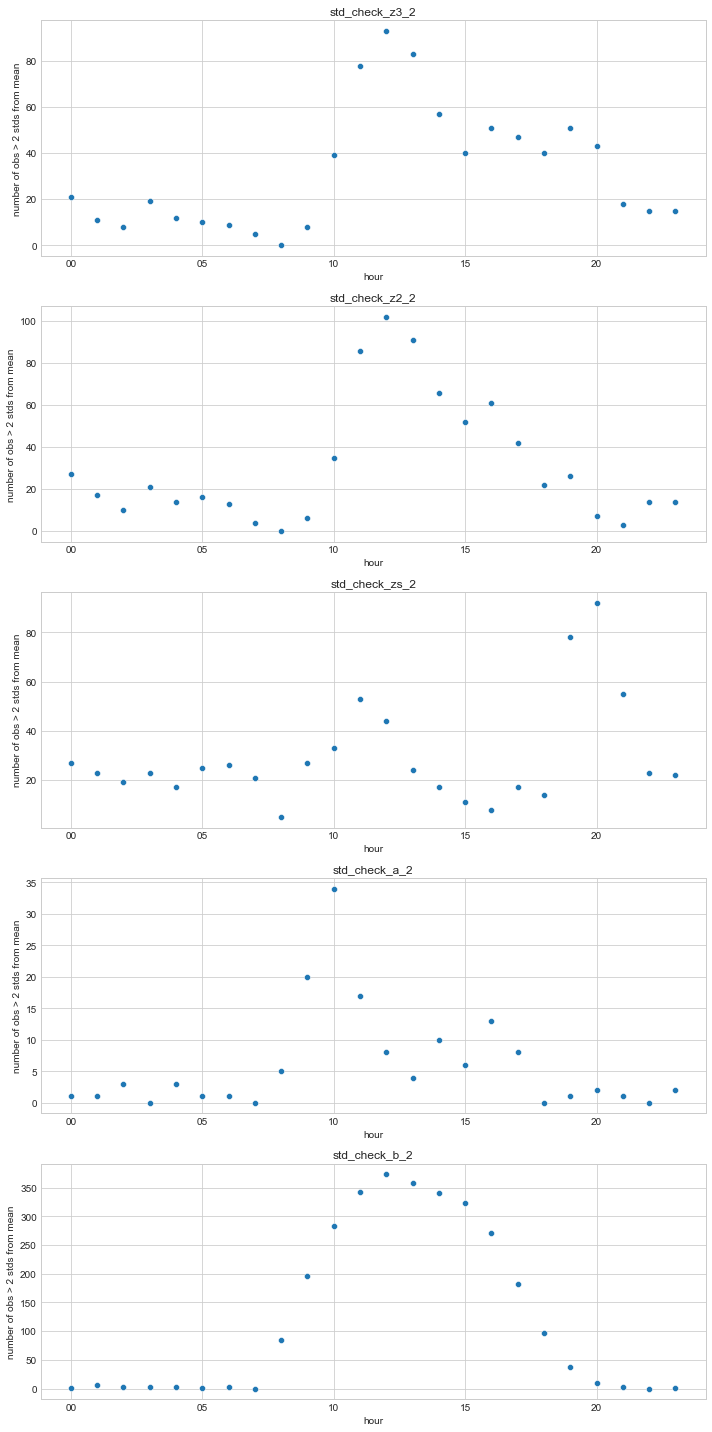

In [19]:
mylist = []
cols  = [x for x in df.columns if ('_2' in x) & ('check' in x)]
for i in cols:
    df_ = df.groupby(['hours'])[i].sum()
    df_.columns = [i]
    df_.index = df_.index.map(''.join)
    mylist.append([i,df_])

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(5,1,figsize= (10,20))
data_ = mylist[0][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[0])
axs[0].set_title(mylist[0][0])
axs[0].set_xlabel('hour')
axs[0].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[0].xaxis.set_major_locator(loc)

data_ = mylist[1][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[1])
axs[1].set_title(mylist[1][0])
axs[1].set_xlabel('hour')
axs[1].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[1].xaxis.set_major_locator(loc)

data_ = mylist[2][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[2])
axs[2].set_title(mylist[2][0])
axs[2].set_xlabel('hour')
axs[2].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[2].xaxis.set_major_locator(loc)

data_ = mylist[3][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[3])
axs[3].set_title(mylist[3][0])
axs[3].set_xlabel('hour')
axs[3].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[3].xaxis.set_major_locator(loc)

data_ = mylist[4][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[4])
axs[4].set_title(mylist[4][0])
axs[4].set_xlabel('hour')
axs[4].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[4].xaxis.set_major_locator(loc)
plt.tight_layout()
plt.savefig(F'{figdir}/obs_stds_above_mean_hours_2018.png')

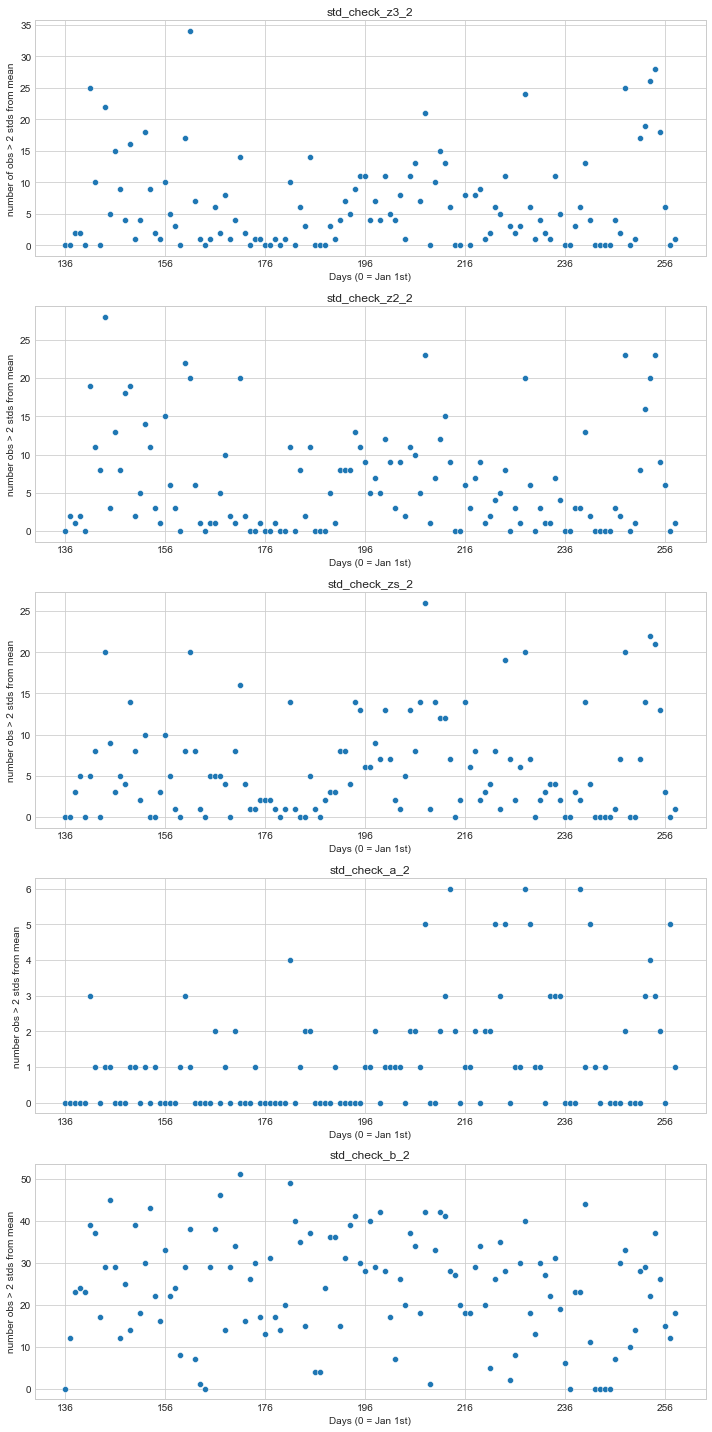

In [18]:
mylist = []
cols  = [x for x in df.columns if ('_2' in x) & ('check' in x)]
for i in cols:
    df_ = df.groupby(['days'])[i].sum()
    df_.columns = [i]
    df_.index = df_.index.map(''.join)
    mylist.append([i,df_])

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

fig,axs = plt.subplots(5,1,figsize= (10,20))
data_ = mylist[0][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[0])
axs[0].set_title(mylist[0][0])
axs[0].set_xlabel('Days (0 = Jan 1st)')
axs[0].set_ylabel('number of obs > 2 stds from mean')
loc = AutoLocator()
axs[0].xaxis.set_major_locator(loc)

data_ = mylist[1][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[1])
axs[1].set_title(mylist[1][0])
axs[1].set_xlabel('Days (0 = Jan 1st)')
axs[1].set_ylabel('number obs > 2 stds from mean')
loc = AutoLocator()
axs[1].xaxis.set_major_locator(loc)

data_ = mylist[2][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[2])
axs[2].set_title(mylist[2][0])
axs[2].set_xlabel('Days (0 = Jan 1st)')
axs[2].set_ylabel('number obs > 2 stds from mean')
loc = AutoLocator()
axs[2].xaxis.set_major_locator(loc)

data_ = mylist[3][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[3])
axs[3].set_title(mylist[3][0])
axs[3].set_xlabel('Days (0 = Jan 1st)')
axs[3].set_ylabel('number obs > 2 stds from mean')
loc = AutoLocator()
axs[3].xaxis.set_major_locator(loc)

data_ = mylist[4][1]
sns.scatterplot(data=data_,x = data_.index,y = data_,ax = axs[4])
axs[4].set_title(mylist[4][0])
axs[4].set_xlabel('Days (0 = Jan 1st)')
axs[4].set_ylabel('number obs > 2 stds from mean')
loc = AutoLocator()
axs[4].xaxis.set_major_locator(loc)
plt.tight_layout()
plt.savefig(F'{figdir}/obs_stds_above_mean_days_2018.png')